In [1]:
import numpy as np
import numba
import time
import scipy

# Helper functions for Least Squares Approximation: Random Projection and Sketching
@numba.jit(nopython=True)
def hamming_weight_array(x):
    count_array = np.zeros_like(x, dtype=np.int8)
    for index in np.ndindex(x.shape):
        count = 0
        value = x[index]
        while value:
            count += value & 1
            value >>= 1
        count_array[index] = count
    return count_array


@numba.jit(nopython=True)
def vectorized_hadamard_rows_with_D(row_indices, n):
    output_rows = np.empty((len(row_indices), n), dtype=np.int8)
    # D = 2 * np.random.randint(0, 2, size=n) - 1
    indices_j = np.arange(n)
    # Compute the Hadamard matrix rows for the given indices
    for count, i in enumerate(row_indices):
        # Compute bitwise AND for every pair i and all j indices
        binary_dot_products = np.bitwise_and(i, indices_j)
        # Compute the Hadamard matrix row entries, then multiply -1 with 0.5 probability
        output_rows[count] = hamming_weight_array(binary_dot_products) * (2 * np.random.randint(0, 2, size=1) - 1)
    return (-1) ** output_rows


# Helper functions for Least Squares Approximation: Random Sampling
def generate_random_projection(r_1, r_2):
    # Generates the randomized unstructured projection (P in our paper)
    return np.random.choice([-np.sqrt(3/r_1), np.sqrt(3/r_1), 0], size=(r_1, r_2), p=[1/6, 1/6, 2/3])


@numba.jit(nopython=True)
def sample_indices(row_indices, n):
    sampled_indices = np.zeros(n, dtype=np.int8)
    for i in range(n):
        random_value = np.random.random()
        cum_sum = 0.0
        for j, weight in enumerate(row_indices):
            cum_sum += weight
            if random_value < cum_sum:
                sampled_indices[i] = j
                break 
    return sampled_indices


def sketch_and_solve(A, b, r, direct=True, precondition_with_QR=False, **kwargs):
    """
    Parameters:
        A: matrix of size m x n
        b: vector of size m (we want to solve Ax = b)
        r: sketch size (dimension we are projecting to)
        direct: whether to use a direct solver or an iterative solver to solve the least squares problem
        precondition_with_QR: whether to precondition the least squares problem with the sketch matrix (for MINRES)
    
    Returns:
        solution to the least squares problem
    """
    m = A.shape[0]
    rand_rows = np.random.choice(m, r, replace=True)
    SH_mD = vectorized_hadamard_rows_with_D(rand_rows, m)
    # Multiply the rows by the Hadamard matrix
    if direct:
        return scipy.linalg.lstsq(SH_mD @ A, SH_mD @ b)[0]
    else:
        if precondition_with_QR:
            _, R = np.linalg.qr(SH_mD @ A)
            gmres_sol = scipy.sparse.linalg.gmres((SH_mD @ A).T @ (SH_mD @ A) @ R, (SH_mD @ A).T @ SH_mD @ b, **kwargs)[0]
            return R @ gmres_sol
        return scipy.sparse.linalg.gmres((SH_mD @ A).T @ (SH_mD @ A), (SH_mD @ A).T @ SH_mD @ b, **kwargs)[0]


def sample_and_solve(A, b, r_1, r_2, k, direct=True, precondition_with_QR=False, **kwargs):
    """
    Parameters:
        A: matrix of size m x n
        b: vector of size m (we want to solve Ax = b)
        r_1: sketch size
        r_2: sketch size
        k: number of samples to take for our sketch
        direct: whether to use a direct solver or an iterative solver to solve the least squares problem
        precondition_with_QR: whether to precondition the least squares problem with the sketch matrix (for MINRES)
    
    Returns:
        solution to the least squares problem
    """
    m = A.shape[0]
    rand_rows = np.random.choice(m, r_1, replace=True)
    P = generate_random_projection(r_1, r_2)
    SH_mD = vectorized_hadamard_rows_with_D(rand_rows, m)
    approximate_lev = np.sum((A @ np.linalg.pinv(SH_mD @ A) @ P) ** 2, axis=1)
    approximate_lev /= np.sum(approximate_lev)
    sampled_indices = sample_indices(approximate_lev, k)
    approximate_lev *= k
    sampled_sketch_A = A[sampled_indices] * approximate_lev[sampled_indices, None]
    sampled_sketch_b = b[sampled_indices] * approximate_lev[sampled_indices]
    if direct:
        return scipy.linalg.lstsq(sampled_sketch_A, sampled_sketch_b)[0]
    else:
        if precondition_with_QR:
            _, R = np.linalg.qr(sampled_sketch_A)
            gmres_sol = scipy.sparse.linalg.gmres(sampled_sketch_A.T @ sampled_sketch_A @ R, sampled_sketch_A.T @ sampled_sketch_b, **kwargs)[0]
            return R @ gmres_sol
        return scipy.sparse.linalg.minres(sampled_sketch_A.T @ sampled_sketch_A, sampled_sketch_A.T @ sampled_sketch_b, **kwargs)[0]

In [10]:

# Generate some overdetermined system
m = 2 ** 16
r = 200
n = 100
A = np.random.randn(m, n)
x = np.random.randn(n, 1)
b = (A @ x) + 0.1 * np.random.randn(m, 1)

start = time.time()
x_lstsq = scipy.linalg.lstsq(A, b)[0]
end = time.time()
print("Time elapsed: ", end - start)

# Grab random rows sampled from H_m @ D
start = time.time()
x_sketch = sketch_and_solve(A, b, r, direct=True)
end = time.time()
print("Time elapsed: ", end - start)
print("Relative error: ", np.linalg.norm(x_lstsq - x_sketch) / np.linalg.norm(x_lstsq))

r_1 = r
r_2 = r
k = r
start = time.time()
x_sampled = sample_and_solve(A, b, r_1, r_2, k, direct=True)
end = time.time()
print("Time elapsed: ", end - start)
print("Relative error: ", np.linalg.norm(x_lstsq - x_sampled) / np.linalg.norm(x_lstsq))

Time elapsed:  0.8786430358886719
Time elapsed:  0.364246129989624
Relative error:  0.009345887531420568
Time elapsed:  0.717872142791748
Relative error:  5.509484635848726


In [3]:
b.shape

(65536,)

In [74]:
elapsed_naive = []
elapsed_sketch = []
elapsed_sampled = []

for logval in range(10, 23):
    print(logval)
    # Generate some overdetermined system
    m = 2 ** logval
    r = 150
    n = 100
    A = np.random.randn(m, n)
    x = np.random.randn(n)
    b = A @ x

    start = time.time()
    x_lstsq = scipy.linalg.lstsq(A, b)[0]
    end = time.time()
    print("Time elapsed: ", end - start)
    elapsed_naive.append(end - start)

    # Grab random rows sampled from H_m @ D
    rand_rows = np.random.choice(m, r, replace=True)
    start = time.time()
    SH_mD = vectorized_hadamard_rows_with_D(rand_rows, m)
    # Multiply the rows by the Hadamard matrix
    x_sketch = scipy.linalg.lstsq(SH_mD @ A, SH_mD @ b)[0]
    end = time.time()
    print("Time elapsed: ", end - start)
    elapsed_sketch.append(end - start)
    print("Relative error: ", np.linalg.norm(x_lstsq - x_sketch) / np.linalg.norm(x_lstsq))

    r_1 = r
    r_2 = r
    k = r
    rand_rows = np.random.choice(m, r_1, replace=True)
    start = time.time()
    P = generate_random_projection(r_1, r_2)
    SH_mD = vectorized_hadamard_rows_with_D(rand_rows, m)
    approximate_lev = np.sum((A @ np.linalg.pinv(SH_mD @ A) @ P) ** 2, axis=1)
    approximate_lev /= np.sum(approximate_lev)
    sampled_indices = sample_indices(approximate_lev, k)
    approximate_lev *= k
    sampled_sketch_A = A[sampled_indices] * approximate_lev[sampled_indices, None]
    sampled_sketch_b = b[sampled_indices] * approximate_lev[sampled_indices]
    x_sampled = scipy.linalg.lstsq(sampled_sketch_A, sampled_sketch_b)[0]
    end = time.time()
    print("Time elapsed: ", end - start)
    elapsed_sampled.append(end - start)
    print("Relative error: ", np.linalg.norm(x_lstsq - x_sampled) / np.linalg.norm(x_lstsq))

10
Time elapsed:  0.05954098701477051
Time elapsed:  0.2608067989349365
Relative error:  3.6557666801050736e-15
Time elapsed:  0.06742978096008301
Relative error:  8.757816729104664e-15
11
Time elapsed:  0.07417893409729004
Time elapsed:  0.03282880783081055
Relative error:  4.046039644604003e-15
Time elapsed:  0.05623579025268555
Relative error:  9.549529892812326e-15
12
Time elapsed:  0.13141989707946777
Time elapsed:  0.04227876663208008
Relative error:  4.304698368740047e-15
Time elapsed:  0.0726919174194336
Relative error:  4.4490164404035565e-15
13
Time elapsed:  0.16709685325622559
Time elapsed:  0.04798316955566406
Relative error:  4.845229040205172e-15
Time elapsed:  0.08532094955444336
Relative error:  5.610692165573142e-15
14
Time elapsed:  0.2868380546569824
Time elapsed:  0.07630395889282227
Relative error:  5.453756115191507e-15
Time elapsed:  0.1449432373046875
Relative error:  4.796810235561535e-15
15
Time elapsed:  0.4752171039581299
Time elapsed:  0.1602160930633545
R

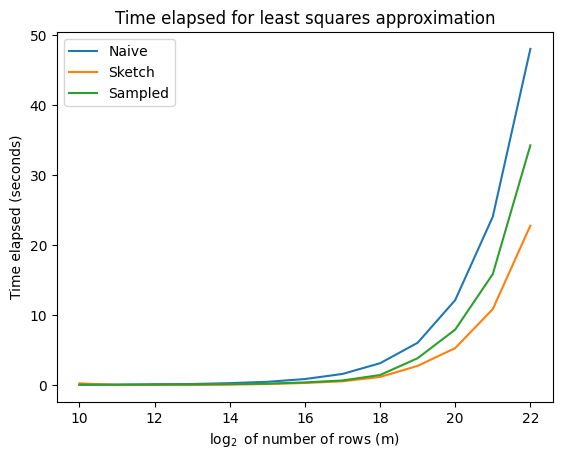

In [77]:
# Plot the results
import matplotlib.pyplot as plt
plt.plot(range(10, 23), elapsed_naive, label="Naive")
plt.plot(range(10, 23), elapsed_sketch, label="Sketch")
plt.plot(range(10, 23), elapsed_sampled, label="Sampled")
plt.xlabel("$\log_2$ of number of rows (m)")
plt.ylabel("Time elapsed (seconds)")
plt.title("Time elapsed for least squares approximation")
plt.legend()
plt.savefig("approx.png")
plt.show()